In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import params
import model
import convert
import stimulus
import matplotlib.pyplot as plt
import jax
import jax.numpy as np

# Experiments 
---

Parameters that works are:
- field_size = (12, 12)
- d = 0.001
- dx = 0.03
- dt = 0.01
- Convert field to shape
- Do not scale parameters and stimuli


## 1. Non chaotic
### 1.1 Stability
Testing the stability of a non chaotic simulations with two rectangular stimuli, delayed by 15000 time steps.

#### Settings
```python
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params1a()
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)
shape = convert.field_to_shape(field_size, dx)
protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, jax.ops.index[-20:, :], 1., protocol1)
protocol2 = stimulus.protocol(start=15000, duration=2, period=0)
s2 = stimulus.rectangular(shape, jax.ops.index[:, -20:], 1., protocol2)
```
#### Results

| dx    | Stable | Quality                    |
|-------|--------|----------------------------|
| 0.08  | NO     | /                          |
| 0.05  | NO     | /                          |
| 0.04  | YES    | UNUSABLE                   |
| 0.03  | YES    | ACCEPTABLE                 |
| 0.025 | YES    | ACCEPTABLE                 |
| 0.02  | YES    | ACCEPTABLE AND SMOOTH      |
| 0.015 | YES    | ACCEPTABLE AND VERY SMOOTH |
| 0.01  | YES    | ACCEPTABLE AND VERY SMOOTH |

### 1.2 Convergence


In [3]:
# simulation inputs (real values)
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params1a()

In [4]:
# infinitesimals
dx = 0.008  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

(1200, 1200)
real tissue size: (12, 12)
{'tau_v_plus': 3.33, 'tau_v1_minus': 19.6, 'tau_v2_minus': 1000, 'tau_w_plus': 667, 'tau_w_minus': 11, 'tau_d': 0.41, 'tau_0': 8.3, 'tau_r': 50, 'tau_si': 45, 'k': 10, 'V_csi': 0.85, 'V_c': 0.13, 'V_v': 0.0055, 'Cm': 1}


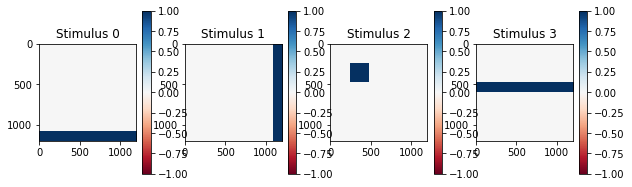

In [5]:
# to computational units
shape = convert.field_to_shape(field_size, dx)

stripe_size = int(shape[0] / 10)

protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, jax.ops.index[-stripe_size:, :], 1., protocol1)

protocol2 = stimulus.protocol(start=15000, duration=2, period=0)
s2 = stimulus.rectangular(shape, jax.ops.index[:, -stripe_size:], 1., protocol2)

protocol3 = stimulus.protocol(start=20000, duration=2, period=0)
s3 = stimulus.rectangular(shape, jax.ops.index[stripe_size*2:stripe_size*4, stripe_size*2:stripe_size*4], 1., protocol3)

protocol4 = stimulus.protocol(start=25000, duration=2, period=0)
s4 = stimulus.rectangular(shape, jax.ops.index[stripe_size*4:stripe_size*5, :], 1., protocol4)

stimuli = [s1, s2, s3, s4]

print(shape)
print("real tissue size:", field_size)
print(cell_parameters)
model.show_stimuli(*stimuli)

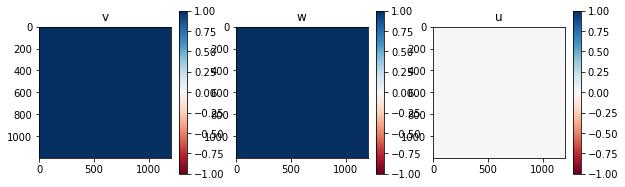

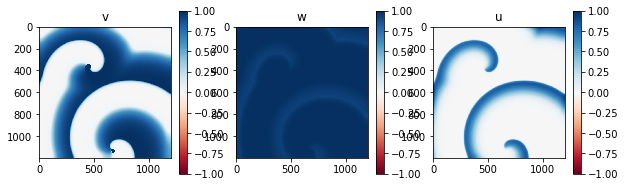

(<Figure size 720x216 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2414862d0>,
       dtype=object))

In [6]:
state = model.init(shape)
t = 0
model.show(state)

state = model.init(shape)
states = model._forward(state, 0, 100000, cell_parameters, np.ones(shape) * d, stimuli, dt, dx)
model.show(states)

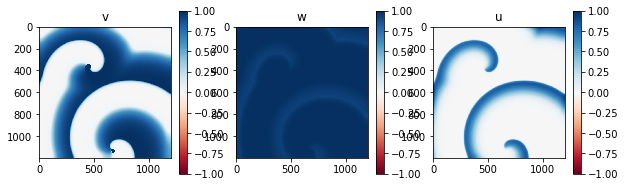

In [7]:
fig, ax = model.show(states)
path = os.path.join("results", "convergence", "chaotic", "dx_%.4f.png" % dx)
fig.savefig(path)

### 1.3 Convergence for a chaotic environment